In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch

In [ ]:
def DiscreteHartleyTransform(X:torch.Tensor,dim,n):
	fft = torch.fft.ifft(X, n=n, dim=dim)
	return torch.real(fft) - torch.imag(fft)

In [ ]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
!git clone --branch HartleyTransform https://github.com/jaysulk/PINO_Applications

Cloning into 'PINO_Applications'...
remote: Enumerating objects: 1261, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 1261 (delta 130), reused 183 (delta 75), pack-reused 1018
Receiving objects: 100% (1261/1261), 539.67 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (868/868), done.
Updating files: 100% (113/113), done.


In [ ]:
%cd /content/drive/MyDrive/Github/PINO_Applications

/content/drive/MyDrive/Github/PINO_Applications


In [ ]:
#!git branch

In [ ]:
#!git fetch origin

In [ ]:
#%cat models/basics.py

In [ ]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
#import torch
# from torch import vmap
from functorch import vmap, grad

from models import FNN2d, FNN2d_AD
from train_utils import Adam
# from train_utils.datasets import BurgersLoader'
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.BurgersEq import BurgersEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import imageio



from tqdm import tqdm
from train_utils.utils import get_grid, save_checkpoint, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D
# from utils import torch2dgrid
from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None


In [ ]:
def FDM_QuasiGeostrophic_Omega(omega, psi, f0, beta, U, dx, dy, dt, nu):
    domega_dx = (omega[:, 2:] - omega[:, :-2]) / (2 * dx)
    domega_dy = (omega[2:, :] - omega[:-2, :]) / (2 * dy)

    d2omega_dx2 = (omega[:, 2:] - 2 * omega[:, 1:-1] + omega[:, :-2]) / (dx ** 2)
    d2omega_dy2 = (omega[2:, :] - 2 * omega[1:-1, :] + omega[:-2, :]) / (dy ** 2)

    dpsi_dx = (psi[:, 2:] - psi[:, :-2]) / (2 * dx)
    dpsi_dy = (psi[2:, :] - psi[:-2, :]) / (2 * dy)

    advection_term_x = U * domega_dx
    advection_term_y = -dpsi_dx * domega_dy
    coriolis_term = f0 * dpsi_dy + beta * dpsi_dx
    diffusion_term = nu * (d2omega_dx2 + d2omega_dy2)

    omega_t = advection_term_x + advection_term_y + coriolis_term + diffusion_term
    omega_next = omega[1:-1, 1:-1] + dt * omega_t

    return omega_next


def PINO_loss_QuasiGeostrophic_Omega(omega, omega0, psi, f0, beta, U, dx, dy, dt, nu):
    batch_size = omega.size(0)
    time_steps = omega.size(1)
    grid_points_x = omega.size(2)
    grid_points_y = omega.size(3)

    omega = omega.reshape(batch_size, time_steps, grid_points_x, grid_points_y)

    index_t = torch.zeros(grid_points_x,).long()
    index_x = torch.tensor(range(grid_points_x)).long()
    index_y = torch.tensor(range(grid_points_y)).long()
    
    boundary_omega = omega[:, index_t, index_x, index_y]
    loss_omega = F.mse_loss(boundary_omega, omega0)

    omega_next = FDM_QuasiGeostrophic_Omega(omega, psi, f0, beta, U, dx, dy, dt, nu)[:, :, :]
    omega_target = omega[:, 1:, 1:-1, 1:-1]
    loss_f = F.mse_loss(omega_next, omega_target)

    return loss_omega, loss_f


In [ ]:
def train_QuasiGeostrophic_Omega(model,
                                  train_loader,
                                  optimizer, 
                                  scheduler,
                                  config,
                                  rank=0,
                                  log=False,
                                  project='PINO-QG-Omega',
                                  group='default',
                                  tags=['default'],
                                  use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']

    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            # Update parameters for the QuasiGeostrophic Omega PDE
            omega = out
            omega0 = x[:, 0, :, :]
            psi = x[:, 1, :, :]
            f0 = config['data']['f0']
            beta = config['data']['beta']
            U = config['data']['U']
            dx = config['data']['dx']
            dy = config['data']['dy']
            dt = config['data']['dt']

            loss_omega, loss_f = PINO_loss_QuasiGeostrophic_Omega(omega, omega0, psi, f0, beta, U, dx, dy, dt, nu)
            total_loss = loss_omega * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [ ]:
def train_QuasiGeostrophic_Omega_padding(model,
                                         train_loader,
                                         optimizer, 
                                         scheduler,
                                         config,
                                         padding=0,
                                         rank=0,
                                         log=False,
                                         project='PINO-QG-Omega',
                                         group='default',
                                         tags=['default'],
                                         use_tqdm=True):
    
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
            
            omega0 = x[:, 0, :, :]
            psi = x[:, 1, :, :]
            f0 = config['data']['f0']
            beta = config['data']['beta']
            U = config['data']['U']
            dx = config['data']['dx']
            dy = config['data']['dy']
            dt = config['data']['dt']

            data_loss = myloss(out.view(batch_size, T, S), y.view(batch_size, T, S))
            
            loss_omega, loss_f = PINO_loss_QuasiGeostrophic_Omega(out.view(batch_size, T, S), omega0, psi, f0, beta, U, dx, dy, dt, nu)
            total_loss = loss_omega * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [ ]:
def eval_QuasiGeostrophic_Omega(model,
                                dataloader,
                                config,
                                device,
                                use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_QuasiGeostrophic_Omega(out, x[:, 0, :, 0])
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



def eval_QuasiGeostrophic_Omega_padding(model,
                                        dataloader,
                                        config,
                                        padding=0,
                                        device=None,
                                        use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_QuasiGeostrophic_Omega(out, x[:, 0, :, 0])
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')


In [ ]:
config_file = 'configs/custom/burgers-0003.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Burgers-0003',
  'total_num': 100,
  'n_train': 90,
  'n_test': 10,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers',
  'save_name': 'Burgers-0003.pt',
  'ckpt': 'checkpoints/Burgers/Burgers-0003.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers-0003'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers/Burgers-0003.pt'}}

In [ ]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
nu = config['data']['nu']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 0.5 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [ ]:
U0.shape

torch.Size([100, 128])

In [ ]:
nu

0.01

In [ ]:
burgers_eq = BurgersEq1D(Nx=Nx, nu=nu, dt=dt, device=device)
save_interval = int(1e-2/dt)
U = vmap(burgers_eq.burgers_driver, in_dims=(0, None))(U0, save_interval) 

In [ ]:
a = U0.cpu().float()
u = U.cpu().float()
display(u.shape,a.shape)

torch.Size([100, 101, 128])

torch.Size([100, 128])

In [ ]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [ ]:
model = FNN2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              activation=config['model']['activation'],
             ).to(device)

In [ ]:
log = False

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [ ]:
#load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

In [ ]:
train_Burgers(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 0, train loss: 5.47017 train f error: 0.00760; data l2 error: 1.04635:   0%|          | 1/500 [00:09<1:21:51,  9.84s/it]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_0.pt


Epoch 100, train loss: 2.35104 train f error: 0.04707; data l2 error: 0.46045:  20%|██        | 101/500 [00:59<04:10,  1.59it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_100.pt


Epoch 200, train loss: 2.33556 train f error: 0.04724; data l2 error: 0.45737:  40%|████      | 201/500 [01:50<03:07,  1.59it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_200.pt


Epoch 300, train loss: 2.35090 train f error: 0.04831; data l2 error: 0.46030:  60%|██████    | 301/500 [02:40<02:05,  1.59it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_300.pt


Epoch 400, train loss: 2.35768 train f error: 0.04750; data l2 error: 0.46181:  80%|████████  | 401/500 [03:30<01:00,  1.63it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_400.pt


Epoch 499, train loss: 2.30960 train f error: 0.04499; data l2 error: 0.45265: 100%|██████████| 500/500 [04:18<00:00,  1.93it/s]


Checkpoint is saved at checkpoints/Burgers/Burgers-0003.pt
Done!


In [ ]:
train_Burgers_padding(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              padding=5,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 0, train loss: 2.34041 train f error: 0.04590; data l2 error: 0.45862:   0%|          | 1/500 [00:00<04:50,  1.72it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_0.pt


Epoch 100, train loss: 2.35864 train f error: 0.04816; data l2 error: 0.46185:  20%|██        | 101/500 [00:51<03:22,  1.97it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_100.pt


Epoch 200, train loss: 2.31840 train f error: 0.04612; data l2 error: 0.45422:  40%|████      | 201/500 [01:41<02:31,  1.97it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_200.pt


Epoch 300, train loss: 2.33994 train f error: 0.04564; data l2 error: 0.45862:  60%|██████    | 301/500 [02:31<01:40,  1.98it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_300.pt


Epoch 400, train loss: 2.33105 train f error: 0.04621; data l2 error: 0.45672:  80%|████████  | 401/500 [03:21<00:49,  1.98it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003_400.pt


Epoch 499, train loss: 2.33044 train f error: 0.04521; data l2 error: 0.45683: 100%|██████████| 500/500 [04:11<00:00,  1.99it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers-0003.pt
Done!


In [ ]:
eval_Burgers(model, test_loader, config, device)

100%|██████████| 10/10 [00:00<00:00, 140.05it/s]

==Averaged relative L2 error mean: 0.4986221432685852, std error: 0.037626469852779974==
==Averaged equation error mean: 0.06316145090386271, std error: 0.022442446122585467==


In [ ]:
eval_Burgers_padding(model, test_loader, config=config, padding=5, device=device)

100%|██████████| 10/10 [00:00<00:00, 140.31it/s]

==Averaged relative L2 error mean: 0.4986972063779831, std error: 0.03763199231293103==
==Averaged equation error mean: 0.06317745158448815, std error: 0.022445870989474166==


In [ ]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
data_x.shape

torch.Size([1, 101, 128, 3])

In [ ]:
use_train_data = False
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
# Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
loader = test_loader
if use_train_data:
    Ntest = Ntrain
    loader = train_loader
# in_dim = config['model']['in_dim']
# out_dim = config['model']['out_dim']

model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))


with torch.no_grad():
    for i, data in enumerate(loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nt + padding, Nx)
#         out = out[..., :-padding, :]
#         pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
#         test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [ ]:
len(preds_y)

10

In [ ]:
key = 0
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [ ]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $s(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $s(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

#plt.show()

<IPython.core.display.Javascript object>

(0.0, 1.0, 0.0, 1.0)

In [ ]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [ ]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [ ]:
save_data(data_path, test_x, test_y, preds_y)

In [ ]:
test_x, test_y, preds_y = load_data(data_path)

In [ ]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

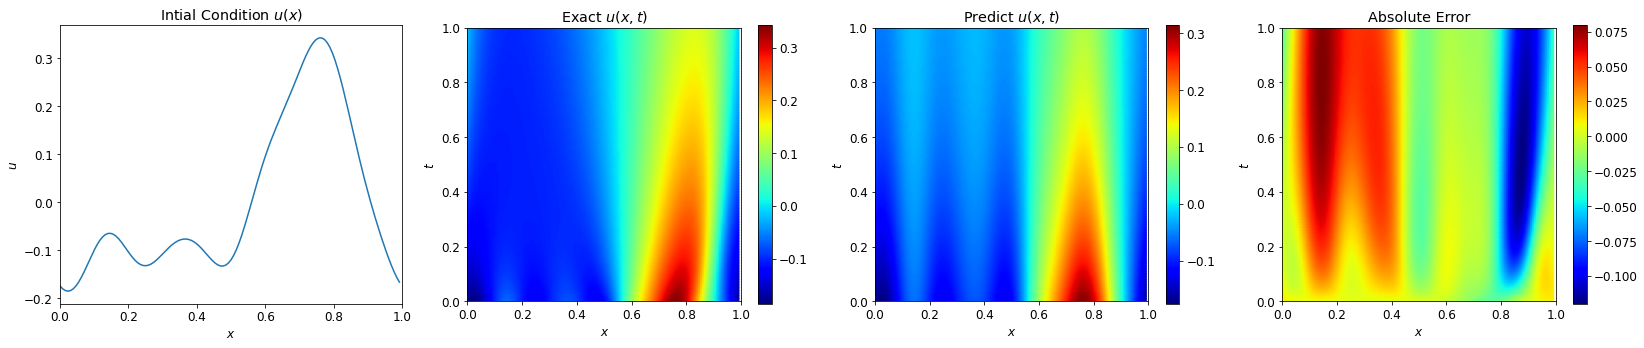

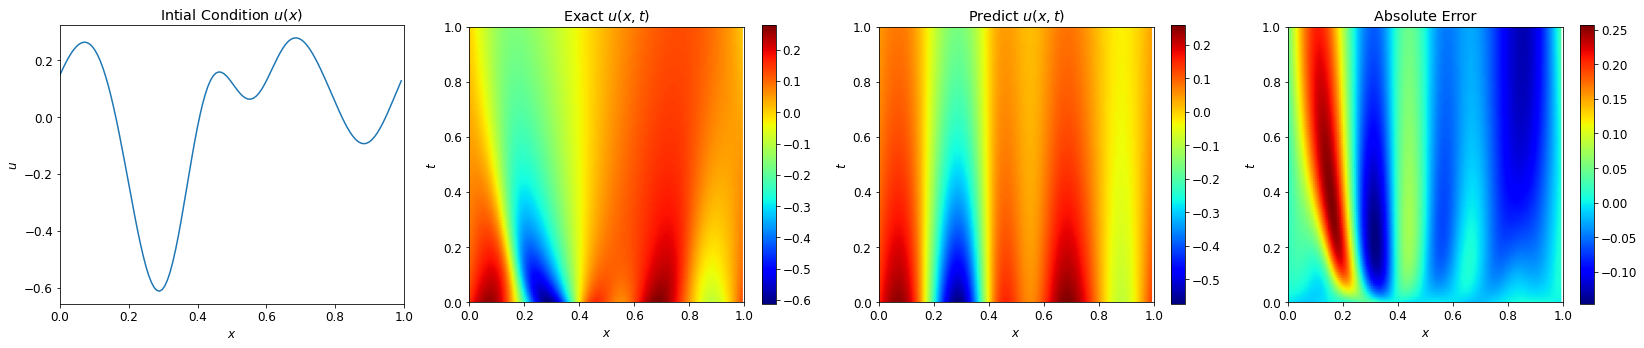

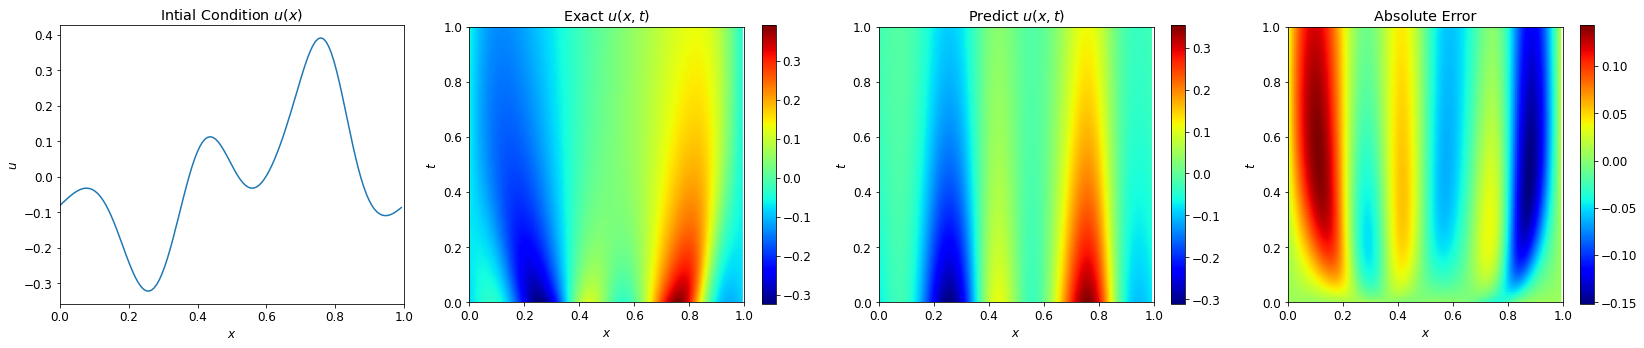

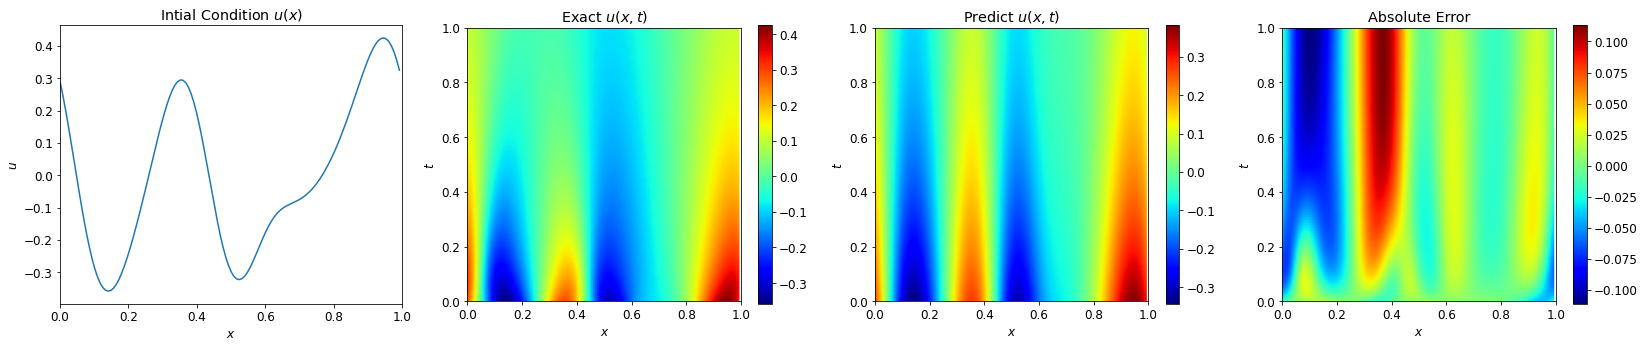

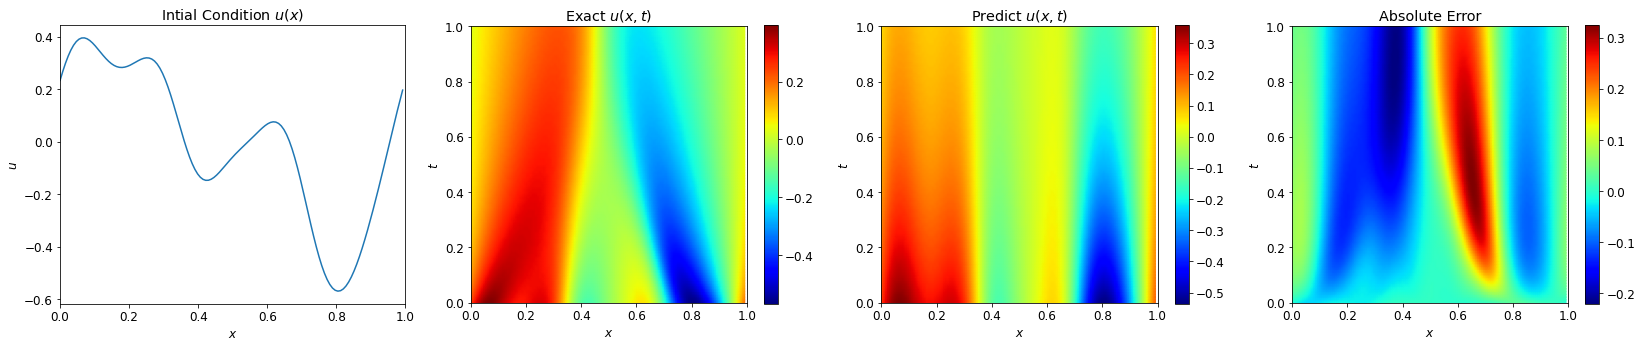

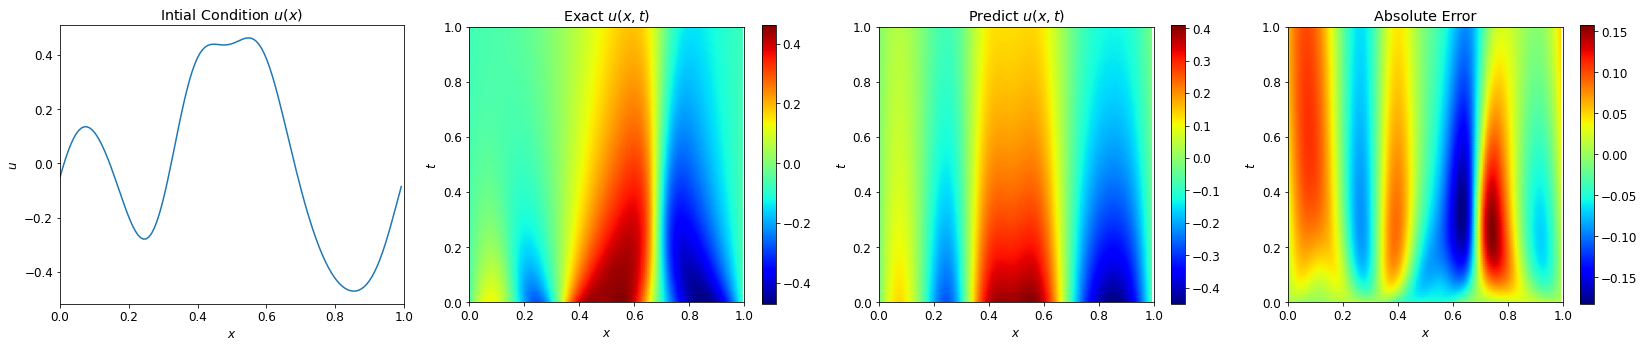

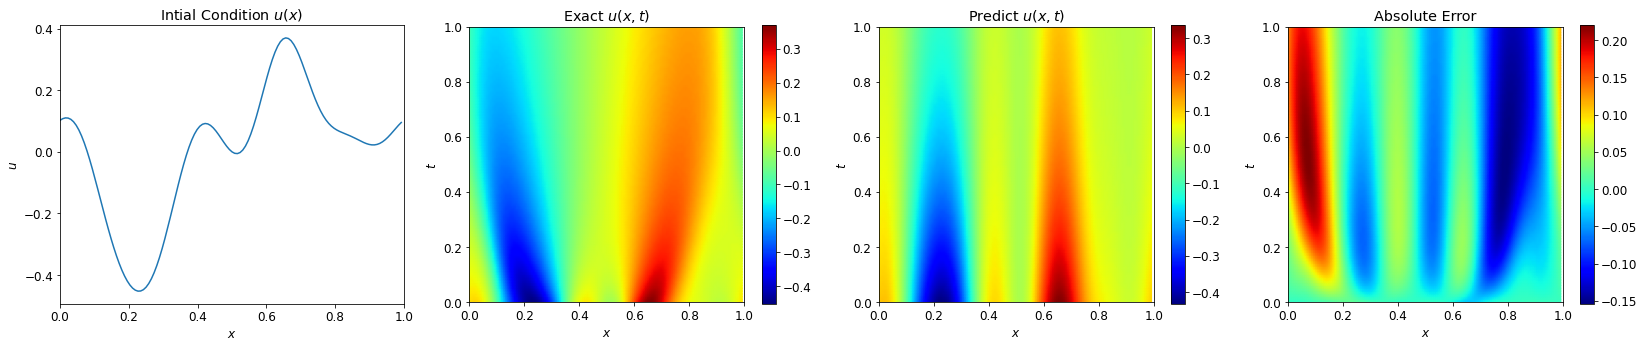

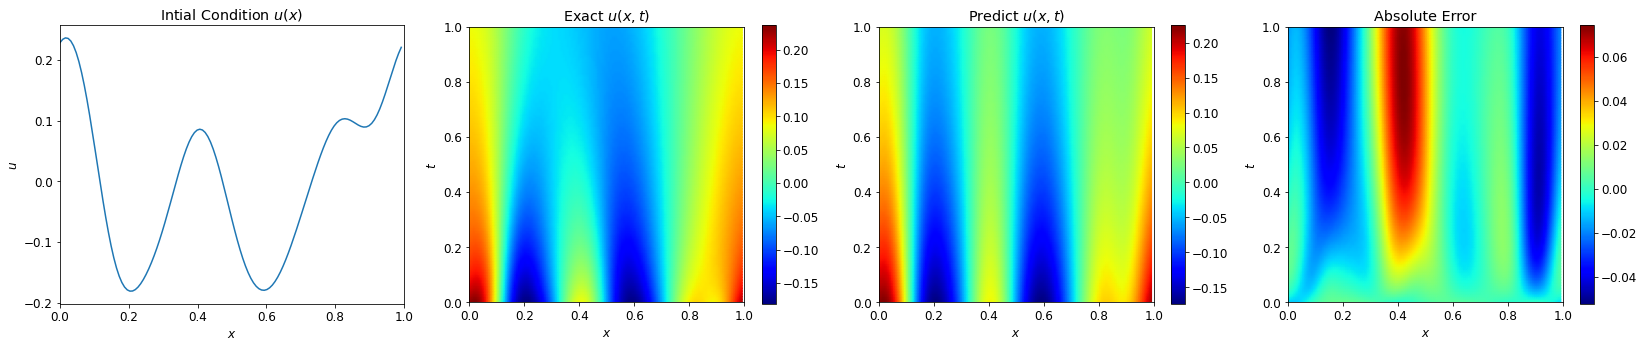

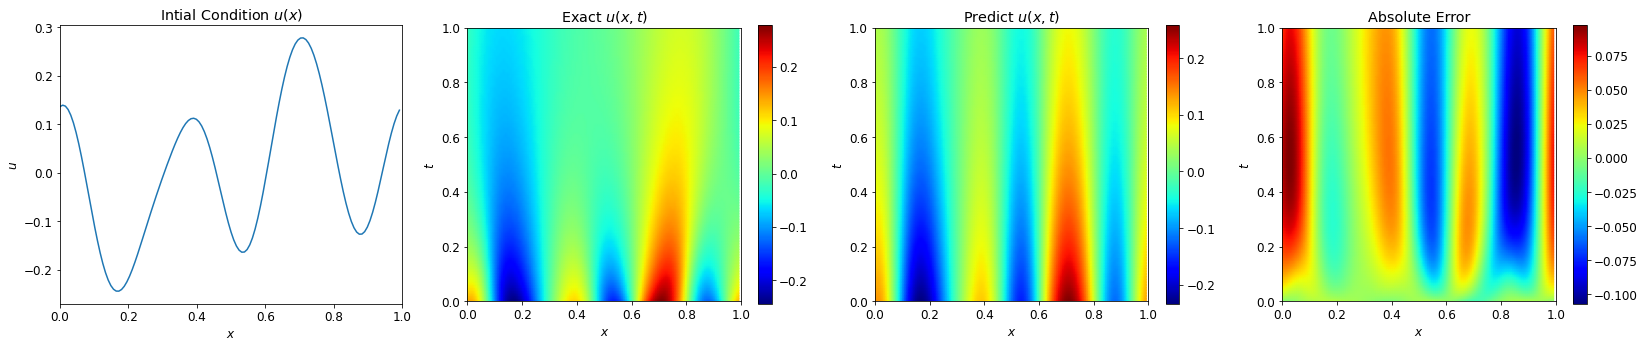

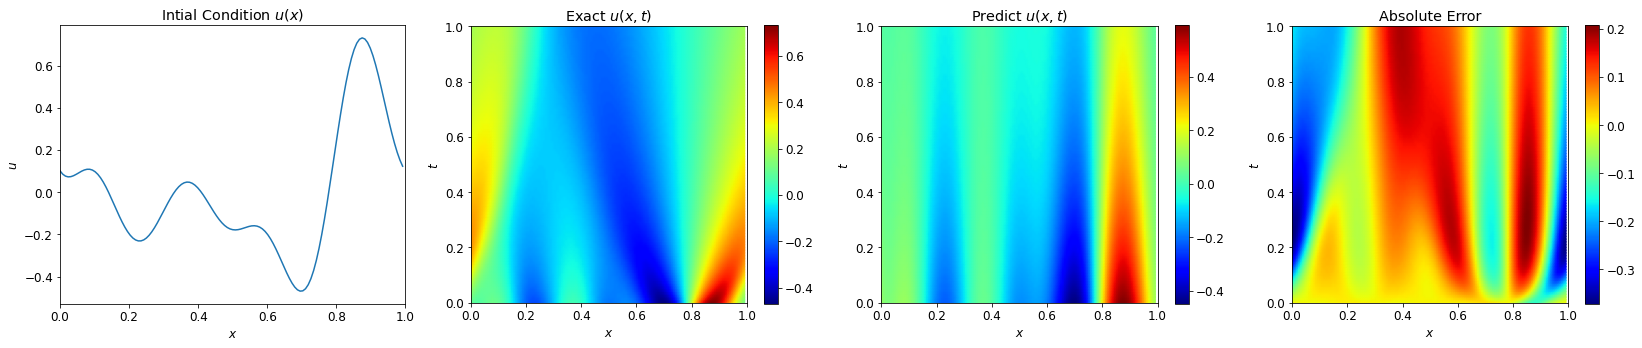

In [ ]:
%matplotlib inline
figures_dir = 'Burgers1D/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers1D_{key}')
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)
